# Analisis predictivo COVID-19
## Entrega Final Anlítica predictiva 
**Andres Cadavid, David Rodriguez, Gabriela Chamorro y Jose Luis Cossio**

### Importar paquetes requeridos

In [10]:
import requests
import pandas as pd
from datetime import date
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

### Extracción de datos

In [11]:
def extract_data(api_url, limit):
    # Funcion para la extraccion de los datos via SODA API ODATA
    data_len = 50000
    offset = 0
    appended_data = []
    while data_len >= limit:
        time.sleep(1)
        params = {'$limit': limit, '$offset': offset}
        response = requests.get(api_url, params=params)
        data = response.json()
        data_len = len(data)
        if 'error' not in data or len(data) > 0:
            df = pd.DataFrame.from_dict(data, orient='columns')
            df['extracted_at_utc'] = pd.to_datetime('now',utc=True)
            appended_data.append(df)
            offset = offset + limit
    return pd.concat(appended_data, ignore_index=True, sort=False)

### Transformación de datos

In [12]:
def data_transform(df, start_date):
    # Funcion transformacion de los datos (Data quality)
    df_in = df
    if 'atenci_n' in df.columns:
        df_in['atenci_n'] = df['atenci_n'].str.strip()
        df_in['atenci_n'] = df['atenci_n'].str.lower()
    delta = date.today() - start_date
    df_dates = pd.DataFrame(pd.date_range(start_date, periods=delta.days, freq='D'), columns=['fecha'])
    df_in['fecha_de_notificaci_n'] = pd.to_datetime(df_in['fecha_de_notificaci_n'])
    df_in['fecha_de_muerte'] = pd.to_datetime(df_in['fecha_de_muerte'])
    df_in['fecha_recuperado'] = pd.to_datetime(df_in['fecha_recuperado'])
    df_in['fecha_diagnostico'] = pd.to_datetime(df_in['fecha_diagnostico'])
    return df_in, df_dates

def data_agg_col(df):
    # Funcion para realizar agregaciones
    df['c_recuperado'] = df['atenci_n'].apply(lambda x : 1 if x == 'recuperado' else 0)
    df['c_fallecido'] = df['atenci_n'].apply(lambda x: 1 if x == 'fallecido' else 0)
    df['c_caso'] = 1
    df_final = df.groupby(['fecha_diagnostico'], as_index=False).agg({'id_de_caso': 'count', 'c_recuperado': 'sum', 'c_fallecido': 'sum'})
    df_casos = df.groupby(['fecha_diagnostico'], as_index=False)['c_caso'].sum()
    df_casos = df_casos.rename(columns={'fecha_diagnostico': 'fecha'})
    df_muertes = df.groupby(['fecha_de_muerte'], as_index=False)['c_fallecido'].sum()
    df_muertes = df_muertes.rename(columns={'fecha_de_muerte':'fecha'})
    df_recuperados = df.groupby(['fecha_recuperado'], as_index=False)['c_recuperado'].sum()
    df_recuperados = df_recuperados.rename(columns={'fecha_recuperado': 'fecha'})
    df_final = df_final.rename(columns={'id_de_caso':'total_casos','c_recuperado':'total_recuperados','c_fallecido':'total_fallecidos'})
    return df_casos, df_muertes, df_recuperados

## ARIMA

### Evaluación del modelo ARIMA para obtener el mejor (p,d,q)

In [13]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

### Evaluacion de la combinación de valores de p, d y q para el modelo ARIMA

In [14]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [15]:
def main():
    # %%
    api_url = "https://www.datos.gov.co/resource/gt2j-8ykr.json"
    df_casos = extract_data(api_url, 50000)
    df_casos, df_dates = data_transform(df_casos,date(2020,3,1))
    df_casos_p,df_muertes,df_recuperados = data_agg_col(df_casos)
    df_full = pd.merge(df_dates, df_casos_p, how='left', on=['fecha'])
    df_full = pd.merge(df_full, df_muertes, how='left', on=['fecha'])
    df_full = pd.merge(df_full, df_recuperados, how='left', on=['fecha'])
    # df_full = df_full.fillna(0)
    df_full['casos_lag'] = df_full['c_caso'].shift(1)
    df_full['fallecidos_lag'] = df_full['c_fallecido'].shift(1)
    df_full['recuperados_lag'] = df_full['c_recuperado'].shift(1)
    df_full = df_full.replace({0: np.nan})
    df_full['casos_diff'] = (df_full['casos_lag'] - df_full['c_caso'])/df_full['c_caso']
    df_full['fallecidos_diff'] = (df_full['fallecidos_lag'] - df_full['c_fallecido']) / df_full['c_fallecido']
    df_full['recuperados_diff'] = (df_full['recuperados_lag'] - df_full['c_recuperado']) / df_full['c_recuperado']
    df_full = df_full.fillna(0)
    df_full.drop(df_full.tail(2).index, inplace=True)
    df_entrenamiento = df_full[['fecha', 'casos_diff']].iloc[:int(round((len(df_full) * 0.8) - 1, 0))]
    test = df_entrenamiento.set_index('fecha')
    #p_v = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    p_v = [0,10,15]
    d_v = [0,1,2]
    q_v = [0, 5, 10]
    #q_v = [0,1,2,3,4,5,6,7,8,9,10]
    #evaluate_models(test['casos_diff'],p_v,d_v,q_v)
    error = evaluate_arima_model(test['casos_diff'], [5,0,0])
    model = ARIMA(test['casos_diff'], order=(5, 0, 0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast(steps=15)[0]
    #plt.plot(df_full['fecha'],df_full['c_caso'])
    # %%

if __name__ == '__main__':
    main()

/Users/Gabriela.Chamorro/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [25]:
api_url = "https://www.datos.gov.co/resource/gt2j-8ykr.json"
df_casos = extract_data(api_url, 50000)
df_casos, df_dates = data_transform(df_casos,date(2020,3,1))

In [26]:
df_casos.head()

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,...,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte,extracted_at_utc
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,recuperado,19,F,Importado,Leve,...,2020-03-06,2020-03-13,2020-03-06T00:00:00.000,PCR,11,380,Otro,NaN,NaT,2020-09-04 04:21:50.287460+00:00
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,recuperado,34,M,Importado,Leve,...,2020-03-09,2020-03-19,2020-03-09T00:00:00.000,PCR,76,724,Otro,NaN,NaT,2020-09-04 04:21:50.287460+00:00
2,3,2020-03-07,05001,Medellín,Antioquia,recuperado,50,F,Importado,Leve,...,2020-03-09,2020-03-15,2020-03-09T00:00:00.000,PCR,5,724,Otro,NaN,NaT,2020-09-04 04:21:50.287460+00:00
3,4,2020-03-09,05001,Medellín,Antioquia,recuperado,55,M,Relacionado,Leve,...,2020-03-11,2020-03-26,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaT,2020-09-04 04:21:50.287460+00:00
4,5,2020-03-09,05001,Medellín,Antioquia,recuperado,25,M,Relacionado,Leve,...,2020-03-11,2020-03-23,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaT,2020-09-04 04:21:50.287460+00:00


In [27]:
df_casos_p,df_muertes,df_recuperados = data_agg_col(df_casos)

In [30]:
df_casos_p.c_caso.mean()

3562.0

In [34]:
df_muertes.c_fallecido.mean()

123.46107784431138

In [35]:
df_recuperados.head()

,fecha,c_recuperado
0,2020-03-13,1
1,2020-03-14,1
2,2020-03-15,1
3,2020-03-17,1
4,2020-03-19,1


In [ ]:
plt.style.use('ggplot')
df.plot(x='day',
        y=['infected', 'suseptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        stacked=True)

In [45]:
df_full = pd.merge(df_dates, df_casos_p, how='left', on=['fecha'])
df_full = pd.merge(df_full, df_muertes, how='left', on=['fecha'])
df_full = pd.merge(df_full, df_recuperados, how='left', on=['fecha'])
df_full.describe()

,c_caso,c_fallecido,c_recuperado
count,178.000000,166.000000,172.000000
mean,3582.000000,124.060241,2787.918605
std,4107.569732,114.578685,3904.945325
min,1.000000,1.000000,1.000000
25%,235.250000,18.000000,98.500000
50%,1424.500000,79.000000,785.500000
75%,6879.750000,240.750000,4586.000000
max,17455.000000,350.000000,14150.000000


In [46]:
df_full.isnull().sum()

fecha            0
c_caso           8
c_fallecido     20
c_recuperado    14
dtype: int64

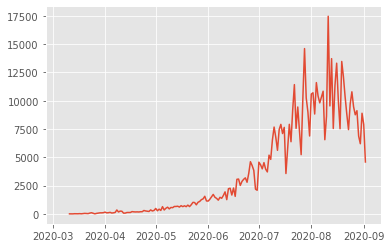

In [51]:
# Visualizar la distribucion de los datos graficamente previo a la normalizacion
plt.plot(df_full['fecha'],df_full['c_caso'])

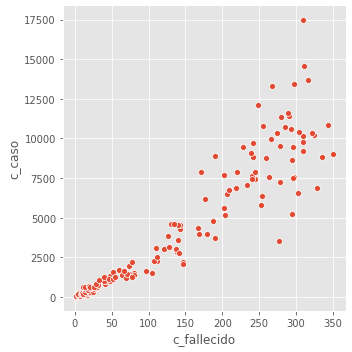

In [50]:
import seaborn as sns
sns.relplot(x='c_fallecido', y='c_caso', data= df_full )

In [52]:
df_full['casos_lag'] = df_full['c_caso'].shift(1)
df_full['fallecidos_lag'] = df_full['c_fallecido'].shift(1)
df_full['recuperados_lag'] = df_full['c_recuperado'].shift(1)
df_full = df_full.replace({0: np.nan})
df_full['casos_diff'] = (df_full['casos_lag'] - df_full['c_caso'])/df_full['c_caso']
df_full['fallecidos_diff'] = (df_full['fallecidos_lag'] - df_full['c_fallecido']) / df_full['c_fallecido']
df_full['recuperados_diff'] = (df_full['recuperados_lag'] - df_full['c_recuperado']) / df_full['c_recuperado']
df_full = df_full.fillna(0)
df_full.drop(df_full.tail(2).index, inplace=True)

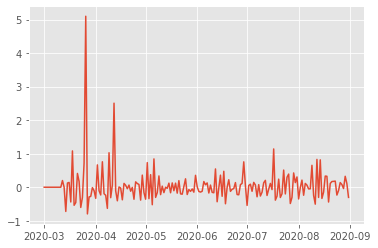

In [53]:
# Visualizar la distribucion de los datos graficamente posterior a la normalizacion
plt.plot(df_full['fecha'],df_full['casos_diff'])

In [20]:
df_casos_p,df_muertes,df_recuperados = data_agg_col(df_casos)
df_full = pd.merge(df_dates, df_casos_p, how='left', on=['fecha'])
df_full = pd.merge(df_full, df_muertes, how='left', on=['fecha'])
df_full = pd.merge(df_full, df_recuperados, how='left', on=['fecha'])
# df_full = df_full.fillna(0)
df_full['casos_lag'] = df_full['c_caso'].shift(1)
df_full['fallecidos_lag'] = df_full['c_fallecido'].shift(1)
df_full['recuperados_lag'] = df_full['c_recuperado'].shift(1)
df_full = df_full.replace({0: np.nan})
df_full['casos_diff'] = (df_full['casos_lag'] - df_full['c_caso'])/df_full['c_caso']
df_full['fallecidos_diff'] = (df_full['fallecidos_lag'] - df_full['c_fallecido']) / df_full['c_fallecido']
df_full['recuperados_diff'] = (df_full['recuperados_lag'] - df_full['c_recuperado']) / df_full['c_recuperado']
df_full = df_full.fillna(0)
df_full.drop(df_full.tail(2).index, inplace=True)

In [21]:
df_full.head()

,fecha,c_caso,c_fallecido,c_recuperado,casos_lag,fallecidos_lag,recuperados_lag,casos_diff,fallecidos_diff,recuperados_diff
0,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Forest

## SIR

In [16]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [17]:
# The SIR model differential equations.
def deriv(state, t, N, beta, gamma):
    S, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

R0 is 2.0


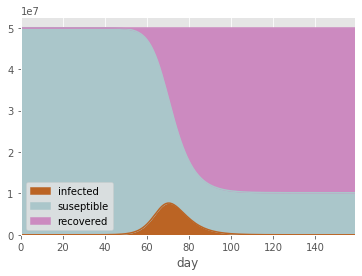

In [18]:
effective_contact_rate = 0.5
recovery_rate = 1/4

# We'll compute this for fun
print("R0 is", effective_contact_rate / recovery_rate)

# What's our start population look like?
# Everyone not infected or recovered is susceptible
total_pop = 50000000
recovered = 0
infected = 1
susceptible = total_pop - infected - recovered

# A list of days, 0-160
days = range(0, 160)

# Use differential equations magic with our population
ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T

# Build a dataframe 
df = pd.DataFrame({
    'suseptible': S.round(),
    'infected': I.round(),
    'recovered': R.round(),
    'day': days
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['infected', 'suseptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        stacked=True)

## Evaluacion de modelos